In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import chi2

# ----------------------------
# Helpers
# ----------------------------
def welch_variance_spectrum(
    eta_m: np.ndarray,
    fs: float,
    nperseg: int,
    noverlap: int,
    window: str = "hann",
    detrend: str = "constant",
):
    """
    Welch variance spectrum S_etaeta(f) (m^2/Hz), with an approximate DOF and 95% CI.
    Returns: f, S, S_lo, S_hi, dof, K
    """
    eta_m = np.asarray(eta_m, dtype=float)
    eta_m = eta_m[np.isfinite(eta_m)]
    if eta_m.size < nperseg:
        raise ValueError("Time series shorter than nperseg after removing NaNs.")

    f, S = welch(
        eta_m,
        fs=fs,
        window=window,
        nperseg=nperseg,
        noverlap=noverlap,
        detrend=detrend,
        scaling="density",   # -> m^2/Hz if eta in meters
        return_onesided=True
    )

    # Welch segment count (K): scipy doesn't return it, so estimate it.
    # With step = nperseg - noverlap, number of segments:
    step = nperseg - noverlap
    K = 1 + (eta_m.size - nperseg) // step
    K = int(max(K, 1))

    # Approx DOF for Welch (simple, commonly used approximation)
    dof = 2 * K

    # 95% confidence limits using chi-square distribution
    alpha = 0.05
    chi2_lo = chi2.ppf(1 - alpha/2, dof)  # 0.975 quantile
    chi2_hi = chi2.ppf(alpha/2, dof)      # 0.025 quantile
    S_lo = (dof * S) / chi2_lo
    S_hi = (dof * S) / chi2_hi

    return f, S, S_lo, S_hi, dof, K


def bulk_stats_from_spectrum(f, S, fmin=None, fmax=None):
    """
    Compute m0, Hm0, Tp, Tm0 from variance spectrum S(f).
    Optional band limits (fmin/fmax) allow restricting integration range.
    """
    f = np.asarray(f, dtype=float)
    S = np.asarray(S, dtype=float)

    mask = np.isfinite(f) & np.isfinite(S) & (f > 0)
    if fmin is not None:
        mask &= (f >= fmin)
    if fmax is not None:
        mask &= (f <= fmax)

    ff = f[mask]
    SS = S[mask]
    if ff.size < 3:
        return dict(m0=np.nan, Hm0=np.nan, fp=np.nan, Tp=np.nan, m1=np.nan, Tm0=np.nan)

    m0 = np.trapezoid(SS, ff)
    m1 = np.trapezoid(ff * SS, ff)

    Hm0 = 4.0 * np.sqrt(m0) if m0 > 0 else np.nan

    # Peak period
    ipeak = np.argmax(SS)
    fp = ff[ipeak]
    Tp = 1.0 / fp if fp > 0 else np.nan

    # Mean period Tm0 = m0 / m1
    Tm0 = (m0 / m1) if (m1 > 0) else np.nan

    return dict(m0=m0, Hm0=Hm0, fp=fp, Tp=Tp, m1=m1, Tm0=Tm0)


def add_period_axis(ax, period_ticks_s=(0.5, 1, 2, 5, 10, 20, 50)):
    """
    Add a top x-axis labeled Period (s) corresponding to bottom frequency axis (Hz).
    Works best for log-scaled frequency axes.
    """
    ax_top = ax.twiny()
    ax_top.set_xscale("log")

    # Match limits in frequency space
    fmin, fmax = ax.get_xlim()
    ax_top.set_xlim(fmin, fmax)

    # Place ticks at frequencies corresponding to selected periods
    period_ticks_s = np.asarray(period_ticks_s, dtype=float)
    f_ticks = 1.0 / period_ticks_s

    # Keep only ticks within current frequency limits
    mask = (f_ticks >= fmin) & (f_ticks <= fmax)
    ax_top.set_xticks(f_ticks[mask])
    ax_top.set_xticklabels([f"{p:g}" for p in period_ticks_s[mask]])

    ax_top.set_xlabel("Period (s)")
    return ax_top
    
    
def analyze_experiment(
    site_dfs: dict,
    color_map: dict,
    experiment_name: str,
    fs: float = 8.0,
    seg_seconds: float = 120.0,
    overlap_frac: float = 0.5,
    fmin: float = 0.02,
    fmax: float = 2.5,
    eta_col: str = "Waves",
):
    """
    Compute Welch variance spectra, 95% CI, and bulk wave statistics
    for one experiment with multiple sites.
    """

    nperseg = int(seg_seconds * fs)
    noverlap = int(overlap_frac * nperseg)

    spec = {}
    stats_rows = []

    for site, df in site_dfs.items():

        # ---- Minimal conversion: DataFrame → NumPy ----
        eta = df[eta_col].to_numpy(dtype=float)
        eta = eta[np.isfinite(eta)]   # optional but safe

        # ---- Welch variance spectrum ----
        f, S = welch(
            eta,
            fs=fs,
            window="hann",
            nperseg=nperseg,
            noverlap=noverlap,
            detrend="constant",
            scaling="density",
            return_onesided=True
        )

        # ---- Welch degrees of freedom (approximate) ----
        step = nperseg - noverlap
        K = 1 + (len(eta) - nperseg) // step
        K = int(max(K, 1))
        dof = 2 * K

        # ---- 95% confidence limits ----
        alpha = 0.05
        Slo = (dof * S) / chi2.ppf(1 - alpha / 2, dof)
        Shi = (dof * S) / chi2.ppf(alpha / 2, dof)

        # ---- Bulk stats ----
        mask = (f >= fmin) & (f <= fmax)
        ff = f[mask]
        SS = S[mask]

        m0 = np.trapezoid(SS, ff)
        m1 = np.trapezoid(ff * SS, ff)

        Hm0 = 4 * np.sqrt(m0)
        fp = ff[np.argmax(SS)]
        Tp = 1 / fp
        Tm0 = m0 / m1

        spec[site] = dict(f=f, S=S, Slo=Slo, Shi=Shi, dof=dof, K=K)

        stats_rows.append({
            "experiment": experiment_name,
            "site": site,
            "Hm0 (m)": Hm0,
            "Tp (s)": Tp,
            "Tm0 (s)": Tm0,
            "segments_K": K,
            "dof": dof
        })

    stats_df = pd.DataFrame(stats_rows)


    fig, ax = plt.subplots(figsize=(9, 6))
    for site in site_dfs.keys():   # <-- uses keys in order
        print(site)
        out = spec[site]
        f, S = out["f"], out["S"]
        mask = (f >= fmin) & (f <= fmax)
    
        # ax.loglog(f[mask], S[mask], color=color_map.get(site), label=site)
        ax.semilogx(f[mask], S[mask], color=color_map.get(site), label=site)

        ax.fill_between(
            f[mask],
            out["Slo"][mask],
            out["Shi"][mask],
            alpha=0.25,
            linewidth=0,
            color=color_map.get(site),
        )
    
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel(r"Variance spectrum $S_{\eta\eta}(f)$ (m$^2$/Hz)")
    ax.set_title(
        
        f"{seg_seconds:.0f}-s segments, {overlap_frac*100:.0f}% overlap"
    )
    ax.grid(True, which="both")
    ax.legend()
    
    # Add top axis in Period (s)
    add_period_axis(ax, period_ticks_s=(0.5, 1, 2, 5, 10, 20, 50))
    
    plot_file_name = f"{experiment_name}_EnergySpectrum.png"
    plt.savefig(plot_file_name, dpi=200)
    fig.tight_layout()

    plt.show()
 


    return spec, stats_df

In [2]:
# Read processed data
data_dir = "/Users/sophiafamely/Documents/ScienceFair2526/"
df_blue1r = pd.read_csv(data_dir+"Datablue1r.csv", index_col=0, parse_dates=True )
df_red1r = pd.read_csv(data_dir+"Datared1r.csv", index_col=0, parse_dates=True )
df_green1r = pd.read_csv(data_dir+"Datagreen1r.csv", index_col=0, parse_dates=True )

df_yellow2r = pd.read_csv(data_dir+"Datayellow2r.csv", index_col=0, parse_dates=True )
df_red2r = pd.read_csv(data_dir+"Datared2r.csv", index_col=0, parse_dates=True )
df_green2r = pd.read_csv(data_dir+"Datagreen2r.csv", index_col=0, parse_dates=True )

Offshore
Rocks
Grass


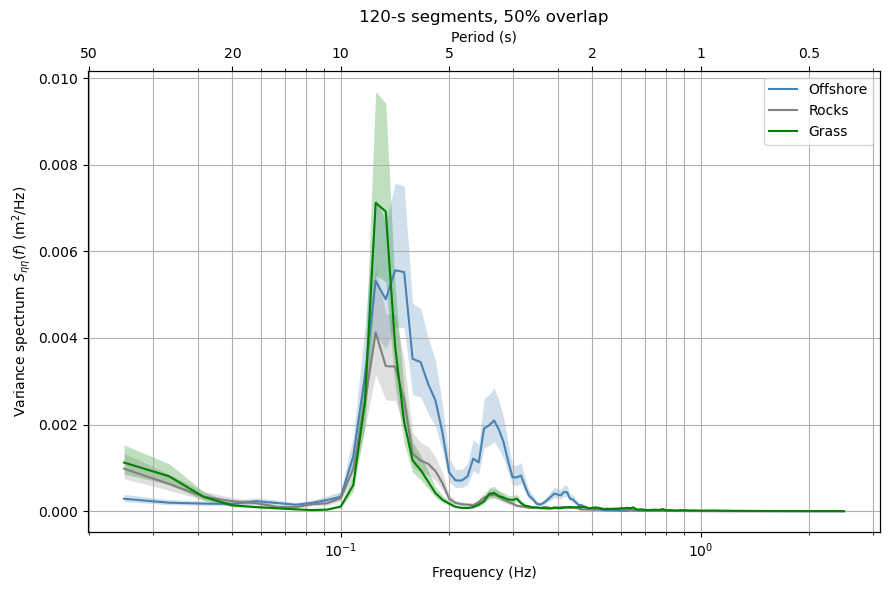

spec keys: ['Offshore', 'Rocks', 'Grass']
stats rows: 3
Deep
Middle
Shallow


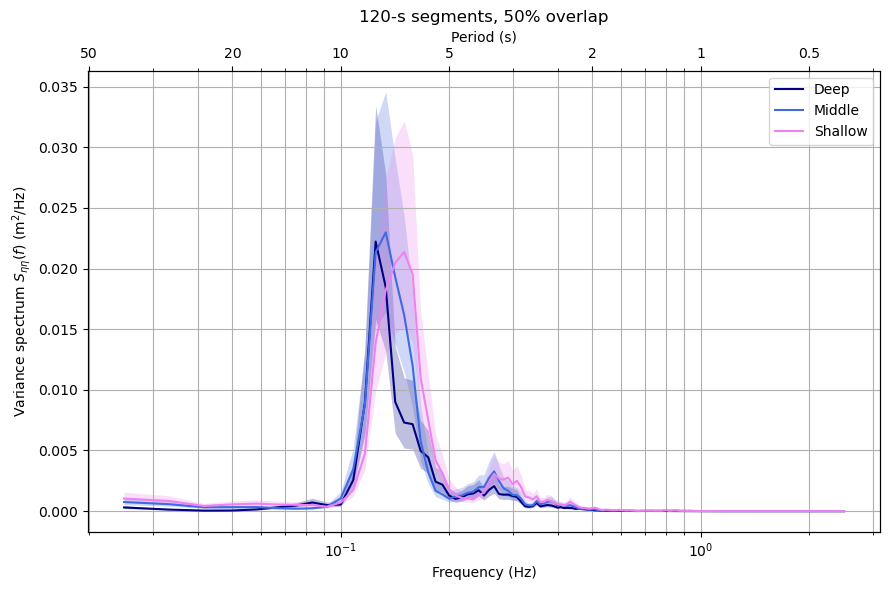

spec keys: ['Deep', 'Middle', 'Shallow']
stats rows: 3


,experiment,site,Hm0 (m),Tp (s),Tm0 (s),segments_K,dof
0,Experiment 1,Offshore,0.094246,7.058824,4.958671,47,94
1,Experiment 1,Rocks,0.064401,8.000000,5.467736,47,94
2,Experiment 1,Grass,0.069867,8.000000,4.823920,47,94
3,Experiment 2 Control,Deep,0.126917,8.000000,5.678823,28,56
4,Experiment 2 Control,Middle,0.145398,7.500000,5.492023,28,56
5,Experiment 2 Control,Shallow,0.154179,6.666667,5.137037,28,56


In [30]:
# Process exp. 1
exp1_sites = {'Offshore': df_blue1r, 'Rocks': df_red1r, 'Grass': df_green1r }
color_map1  = {
    "Offshore": "steelblue",       # blue
    "Rocks":    "gray",       # red
    "Grass":    "g",       # green
}
spec1, stats1 = analyze_experiment(exp1_sites, color_map1, "Experiment 1")
print("spec keys:", list(spec1.keys()))
print("stats rows:", len(stats1))

# Process exp. 2
exp2_sites = {'Deep': df_red2r, 'Middle': df_yellow2r, 'Shallow': df_green2r }
color_map2  = {
    
    "Deep":    "navy",       # red
    "Middle":     "royalblue",    # yellow
    "Shallow":    "violet",       # green
}
spec2, stats2 = analyze_experiment(exp2_sites, color_map2, "Experiment 2 Control")
print("spec keys:", list(spec2.keys()))
print("stats rows:", len(stats2))


# Combine stats tables if desired:
stats_all = pd.concat([stats1, stats2], ignore_index=True)
display(stats_all)
stats_all.to_csv("wave_bulk_stats_welch.csv", index=False)